In [56]:
import numpy as np
import matplotlib.pyplot as plt

import itertools
import time
import os

import glob

from natsort import natsorted
from IPython.display import clear_output, display

from tqdm.auto import tqdm

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

In [2]:
fblocks = np.array([
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(4,0,0)],
    [(0,0,0),(1,0,1),(2,0,0),(2,-1,1),(1,1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(0,1,1),(2,-1,1)],
    [(0,0,0),(1,0,1),(2,0,0),(-1,0,1),(0,-1,1)],
    [(0,0,0),(-1,0,1),(1,0,1),(0,1,1),(0,-1,1)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,-1,0)],
    [(0,0,0),(1,0,1),(2,0,0),(3,0,1),(0,1,1)],
    [(0,0,0),(0,1,1),(2,0,0),(2,1,1),(1,1,0)],
    [(0,0,1),(1,0,0),(2,0,1),(0,1,0),(0,2,1)],
    [(0,0,1),(-1,0,0),(0,1,0),(1,1,1),(2,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0),(-1,1,0)],
    [(0,0,0),(1,0,1),(0,1,1),(1,1,0)],
    [(0,0,0),(1,1,0),(2,2,0),(0,1,1),(1,2,1)]
])


board_size = 8

fblocks = np.array([
    [(0,0,0)],
    [(0,0,0),(-1,0,1),(0,-1,1)],
    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
    [(0,0,0),(-1,0,1),(0,-1,1),(0,-2,0)],
    [(0,0,1),(-1,0,0),(0,-1,0),(0,-2,1)],
    [(0,0,0),(0,1,1),(0,2,0),(0,3,1)],
    [(0,0,0),(0,1,1),(0,2,0)],
    [(0,0,1),(0,1,0)]
])

board_size = 5

blocks = []
for block in fblocks:
    blocks.append(np.array(block))
fblocks = np.array(blocks).copy()

dcol = np.random.rand(len(fblocks),3)

In [3]:
def rot_mat(angle):
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.round(np.array(((c,-s), (s, c))))
    return R

def rotation(block, rot=0):
    block = block.copy()
    angles = [0,90,180,270]
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : np.matmul(rot_mat(angles[rot]), x), rblock))).astype(int)
    block[...,:-1] = rblock
    return block

def translation(block, vector):
    block = block.copy()
    rblock = block[...,:-1]
    rblock = np.array(list(map(lambda x : x + vector, rblock)))
    block[...,:-1] = rblock
    return block

In [4]:
def move_block(block, setting):
    block = rotation(block,setting[-1])
    block = translation(block,setting[:-1])
    return block

def plot_block(block, setting = [0,0,0], *args, **kwargs):
    block = move_block(block, setting)
    mask = block[...,-1] == 0
    plt.plot(block[mask,0], block[mask,1], marker='s', fillstyle='top', linewidth=0, *args, **kwargs)
    plt.plot(block[~mask,0], block[~mask,1], marker='s', fillstyle='bottom', linewidth=0, *args, **kwargs)
    
def plot_blocks(blocks, settings = None, filename = None, *args, **kwargs):
    fig = plt.figure(figsize=(10,10))
    edges = np.array([[0,0], [0,board_size-1], [board_size-1,board_size-1], [board_size-1,0], [0,0]])
    plt.plot(edges[:,0], edges[:,1], color='r')
    for idx,block in enumerate(blocks):
        setting = [0,0,0] if settings is None else settings[idx]
        plot_block(block, setting, markersize=40, color = dcol[idx])
    plt.xlim(-1, board_size)
    plt.ylim(-1, board_size)
    
    if filename is not None:
        plt.savefig(f'images/{filename}', bbox_inches='tight', dpi=100)
        plt.close(fig)

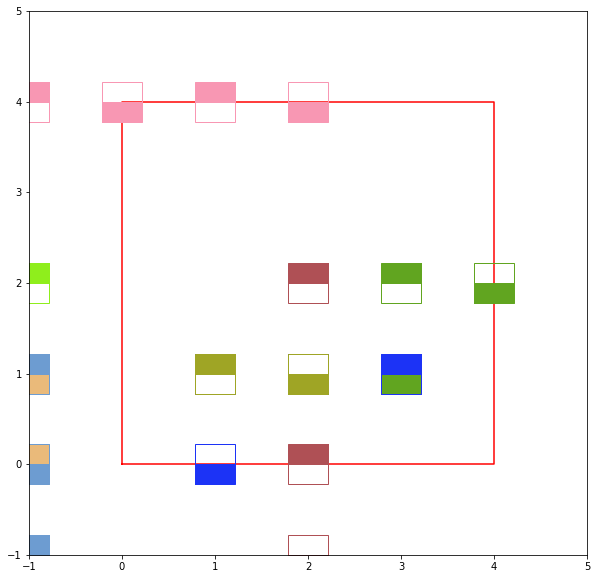

In [5]:
vecs = [np.random.randint(-1,board_size,2) for i in range(len(fblocks))]
rots = [np.random.randint(0,4) for i in range(len(fblocks))]

settings = [(*vec, rot) for vec,rot in zip(vecs,rots)]

plot_blocks(fblocks, settings)

In [6]:
# brute force it
brute_positions_x = np.array(list(range(board_size)))
brute_positions_y = brute_positions_x
brute_rotations = np.array(list(range(4)))

iterables = [brute_positions_x, brute_positions_y, brute_rotations]

all_combs = np.array(list(itertools.product(*iterables)))

In [62]:
def board_check(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    if any(n < 0 for n in flats.ravel()) or any(n >= board_size for n in flats.ravel()):
        return False
    return True

def duplication_check(blocks):
    rblocks = np.array([block[...,:-1] for block in blocks])
    flats = np.concatenate(rblocks)
    mat = np.zeros((board_size, board_size))
    for pos in flats:
        mat[pos[0]][pos[1]] += 1
        
    nflats = mat.ravel()
    if any(n > 1 for n in nflats.ravel()):
        return False
    return True

def single_check(case):
        if np.sum(case[:-1]) % 2 != case[-1]:
            return False
        return True

def fillstyle_check(blocks):
    flats = np.concatenate(blocks)       
    if any(not single_check(case) for case in flats):
        return False
    return True

def make_checks(blocks):
    if not board_check(blocks):
        return False
    if not duplication_check(blocks):
        return False
    if not fillstyle_check(blocks):
        return False
    return True

In [67]:
def solution(i, blocks, counter):
    for comb in all_combs:
        counter +=1 
        if i < len(fblocks):
            blocks[i] = move_block(fblocks[i], comb)
            if i < len(fblocks)-1:
                if not make_checks(blocks[:i+1]):
                    continue
                solution(i+1, blocks, counter)

                if isinstance(blocks[-1], float):
                    pass
                else:
                    if not make_checks(blocks):
                        continue
                    break
            else:
                if not make_checks(blocks):
                    continue
                break
    return blocks, counter

In [68]:
start_time = time.time()

blocks = np.zeros(len(fblocks)).astype(object)
counter = 0

output, c = solution(0, blocks, counter)

elapsed_time = time.time() - start_time
print(f'Elapsed time {elapsed_time:.2f} s')
print(f'Tested {c} combinations')

Elapsed time 25.87 s
Tested 0 combinations


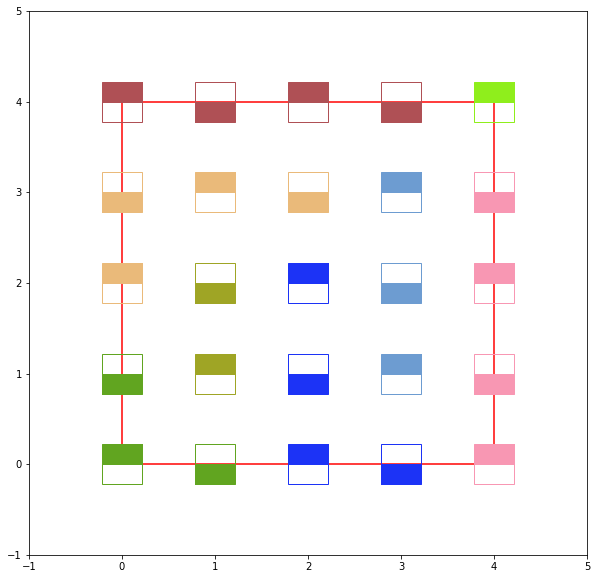

In [61]:
plot_blocks(output)

In [14]:
import solution as solution2

In [17]:
start_time = time.time()

blocks = np.zeros(len(fblocks)).astype(object)
counter = 0

output, c = solution2.solution(0,blocks, counter)

elapsed_time = time.time() - start_time
print(f'Elapsed time {elapsed_time:.2f} s')
print(f'Tested {c} combinations')

Elapsed time 2.35 s
Tested 11711 combinations
